Total images loaded: 10015
Epoch 1/50
250/250 [==============================] - 134s 404ms/step - loss: 0.8685 - accuracy: 0.6992 - val_loss: 0.7319 - val_accuracy: 0.7359
Epoch 2/50
250/250 [==============================] - 100s 400ms/step - loss: 0.5979 - accuracy: 0.7845 - val_loss: 0.5681 - val_accuracy: 0.7873
Epoch 3/50
250/250 [==============================] - 98s 394ms/step - loss: 0.4980 - accuracy: 0.8163 - val_loss: 0.5122 - val_accuracy: 0.8120
Epoch 4/50
250/250 [==============================] - 96s 384ms/step - loss: 0.4204 - accuracy: 0.8482 - val_loss: 0.4588 - val_accuracy: 0.8342
Epoch 5/50
250/250 [==============================] - 99s 397ms/step - loss: 0.3668 - accuracy: 0.8694 - val_loss: 0.4441 - val_accuracy: 0.8332
Epoch 6/50
250/250 [==============================] - 96s 385ms/step - loss: 0.3350 - accuracy: 0.8784 - val_loss: 0.4436 - val_accuracy: 0.8473
Epoch 7/50
250/250 [==============================] - 101s 403ms/step - loss: 0.2975 - accuracy: 0.89

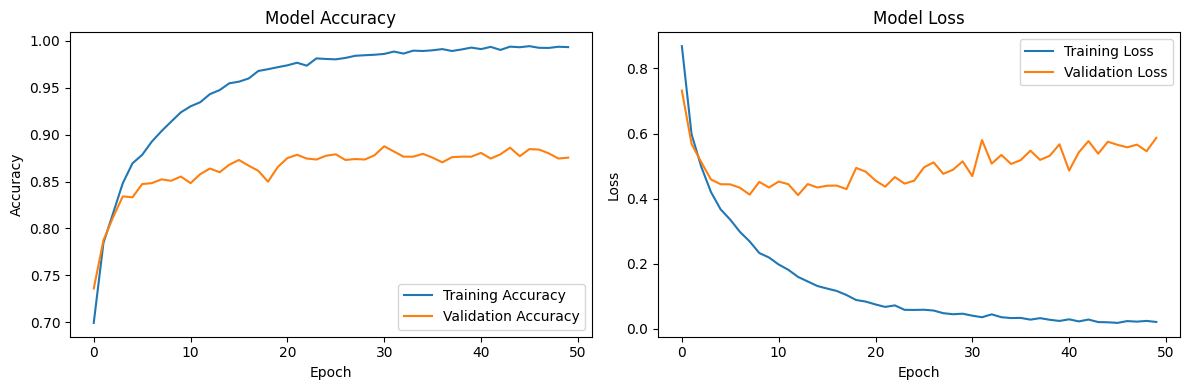

Test accuracy: 0.8785
62/62 [==============================] - 17s 257ms/step
              precision    recall  f1-score   support

       akiec       0.03      0.03      0.03        60
         bcc       0.05      0.05      0.05       103
         bkl       0.12      0.13      0.12       221
          df       0.03      0.03      0.03        33
         mel       0.10      0.08      0.09       208
          nv       0.67      0.69      0.68      1328
        vasc       0.03      0.03      0.03        31

    accuracy                           0.49      1984
   macro avg       0.15      0.15      0.15      1984
weighted avg       0.48      0.49      0.48      1984



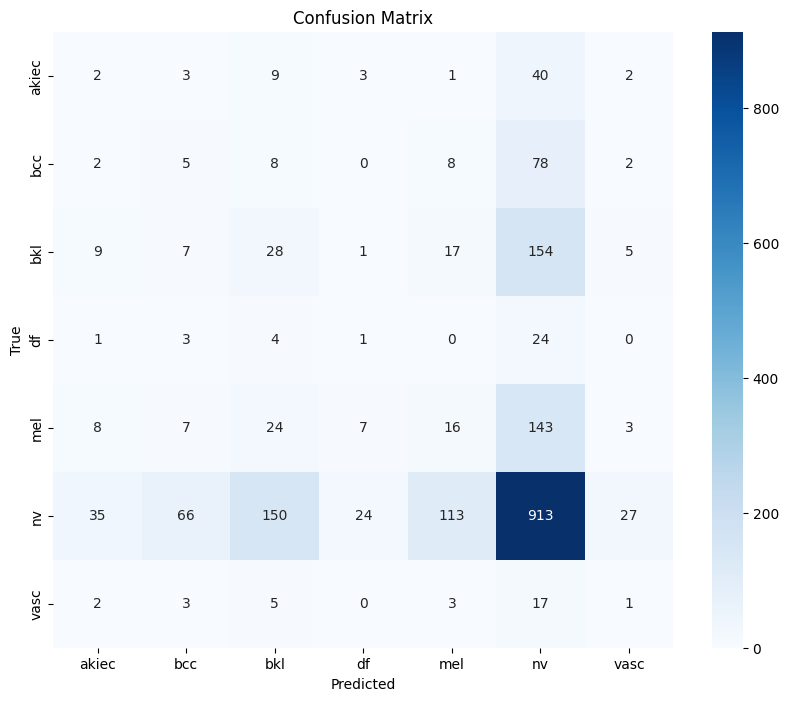

1/1 [==============================] - 0s 77ms/step


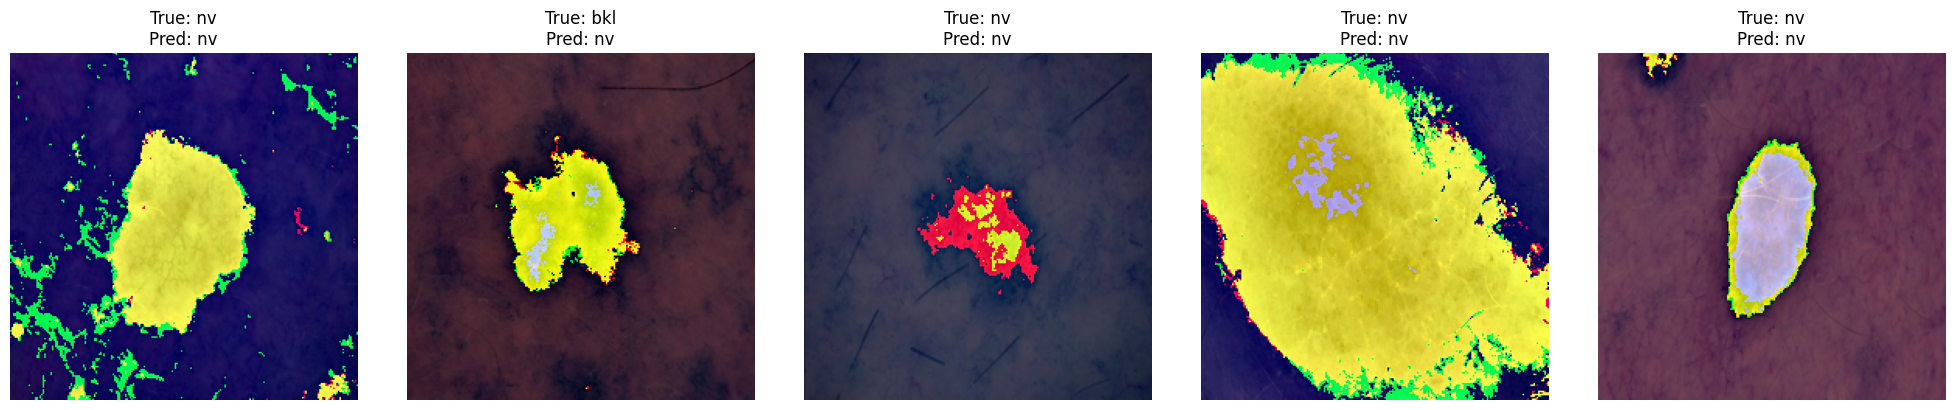

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configure GPU to allow memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define paths
path_part_1 = "d1_images/HAM10000_images_part_1"
path_part_2 = "d2_images/HAM10000_images_part_2"
metadata_path = "HAM10000_metadata.csv"

# Load metadata CSV
metadata = pd.read_csv(metadata_path)

# Function to load images
def load_images(path):
    images = {}
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)
            images[filename] = img
    return images

# Load images from both parts
images_part_1 = load_images(path_part_1)
images_part_2 = load_images(path_part_2)

# Combine the two parts
combined_images = {**images_part_1, **images_part_2}

print(f"Total images loaded: {len(combined_images)}")

# Prepare the data
def prepare_data(image_dict, metadata_df, target_size=(224, 224)):
    X = []
    y = []
    for image_id, image in image_dict.items():
        img = image.resize(target_size)
        img_array = np.array(img)
        X.append(img_array)
        
        # Get the corresponding diagnosis
        dx = metadata_df[metadata_df['image_id'] == image_id.split('.')[0]]['dx'].values[0]
        y.append(dx)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Prepare the data
X, y = prepare_data(combined_images, metadata, target_size=(224, 224))

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Create data generators
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(len(le.classes_), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(X_test) // 32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(X_test) // 32, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(validation_generator, steps=len(X_test) // 32)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test[:len(y_pred_classes)], axis=1)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sample predictions
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, n_samples, i+1)
    
    # Get the original image (before preprocessing)
    original_img = X_test[idx]
    
    # Display the original image
    plt.imshow(original_img.astype(np.uint8))
    
    true_label = le.classes_[np.argmax(y_test[idx])]
    pred_label = le.classes_[np.argmax(model.predict(original_img[np.newaxis, ...]))]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
